In [4]:
import os 
import torch 
from torch import nn 
from d2l import torch as d2l

In [6]:
d2l.DATA_HUB['aclImdb'] = (d2l.DATA_URL + 'aclImdb_v1.tar.gz','01ada507287d82875905620988597833ad4e0903')
data_dir = d2l.download_extract('aclImdb', 'aclImdb')

In [8]:
def read_imdb(data_dir, is_train):
    data, labels = [], []
    for label in ('pos', 'neg'):
        folder_name = os.path.join(data_dir, 'train' if is_train else 'test', label)
        for file in os.listdir(folder_name):
            with open(os.path.join(folder_name, file), 'rb') as f:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1 if label =='pos' else 0)
    return data, labels

train_data = read_imdb(data_dir, is_train=True) 
print('# trainings:', len(train_data[0])) 
for x, y in zip(train_data[0][:3], train_data[1][:3]):
    print('label:', y, 'review:', x[:60])

# trainings: 25000
label: 1 review: Ok, so it borrows a little from "It's a Wonderful Life", but
label: 1 review: The zenith of two brilliant careers. David Lynch, better kno
label: 1 review: The opening credits make for a brilliant, atmospheric piece 


In [9]:
train_tokens = d2l.tokenize(train_data[0], token='word')
vocab = d2l.Vocab(train_tokens, min_freq=5, reserved_tokens=['<pad>'])

(array([ 553., 2373., 6820., 4834., 2817., 1848., 1380., 1005.,  759.,
         581.,  437.,  349.,  257.,  207.,  174.,  133.,  116.,   85.,
          75.]),
 array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450., 500.,
        550., 600., 650., 700., 750., 800., 850., 900., 950.]),
 <BarContainer object of 19 artists>)

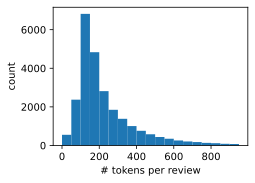

In [ ]:
d2l.set_figsize() 
d2l.plt.xlabel('# tokens per review') 
d2l.plt.ylabel('count') 
d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50))

In [10]:
num_steps = 500 
# sequence length 
train_features = torch.tensor([d2l.truncate_pad( 
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens]) 
print(train_features.shape)

torch.Size([25000, 500])


In [11]:
train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), 64)
for X, y in train_iter:
    print('X:', X.shape,', y:', y.shape)
    break
print('# batches:', len(train_iter))

X: torch.Size([64, 500]) , y: torch.Size([64])
# batches: 391


In [12]:
def load_data_imdb(batch_size, num_steps=500):
    data_dir = d2l.download_extract('aclImdb', 'aclImdb')
    train_data = read_imdb(data_dir, True) 
    test_data = read_imdb(data_dir, False)
    train_tokens = d2l.tokenize(train_data[0], token='word')
    test_tokens = d2l.tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad( vocab[line], num_steps, vocab['<pad>']) for line in train_tokens]) 
    test_features = torch.tensor([d2l.truncate_pad(
    vocab[line], num_steps, vocab['<pad>']) for line in test_tokens]) 
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])), batch_size) 
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])), batch_size, is_train=False) 
    return train_iter, test_iter, vocab

In [13]:
import torch 
from torch import nn 
from d2l import torch as d2l

batch_size = 64 
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [14]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers = num_layers, bidirectional=True)
        self.decoder = nn.Linear(4*num_hiddens, 2)
    
    def forward(self, inputs):
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [15]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus() 
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

In [16]:
def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights)

BiRNN(
  (embedding): Embedding(49346, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=2, bias=True)
)

In [17]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')

In [18]:
embeds = glove_embedding[vocab.idx_to_token] 
embeds.shape

torch.Size([49346, 100])

In [19]:
net.embedding.weight.data.copy_(embeds) 
net.embedding.weight.requires_grad = False

loss 0.298, train acc 0.874, test acc 0.855
1514.0 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3), device(type='cuda', index=4), device(type='cuda', index=5), device(type='cuda', index=6), device(type='cuda', index=7)]


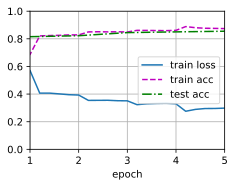

In [ ]:
lr, num_epochs = 0.01, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction="none")
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [20]:
def predict_sentiment(net, vocab, sequence):
    sequence = torch.tensor(vocab[sequence.split()], device=d2l.try_gpu())
    label = torch.argmax(net(sequence.reshape(1,-1)), dim=1)
    return 'positive' if label ==1 else 'negative'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [ ]:
predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [21]:
import torch 
from torch import nn 
from d2l import torch as d2l

batch_size = 64 
train_iter, test_iter, vocab = d2l.load_data_imdb(batch_size)

In [22]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i:i+w]*K).sum()
    return Y


In [23]:
X, K = torch.tensor([0, 1, 2, 3, 4, 5, 6]), torch.tensor([1, 2]) 
corr1d(X, K)

tensor([ 2.,  5.,  8., 11., 14., 17.])

In [24]:
def corr1d_multi_in(X, K):
    return sum(corr1d(x, k) for x, k in zip(X, K))

X = torch.tensor([[0,1,2,3,4,5,6], [1, 2, 3, 4, 5, 6, 7], [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1,2],[3,4],[-1,-3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

In [25]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 2)
        self.pool = nn.AdaptiveAvgPool1d(1) #max pooling
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2*embed_size, c, k))
        
    def forward(self, inputs):
        embeddings = torch.cat((self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        embeddings = embeddings.permute(0,2,1)
        encoding = torch.cat([torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
                              for conv in self.convs], dim=1)
        outputs = self.decoder(self.dropout(encoding))
        return outputs

In [26]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100] 
devices = d2l.try_all_gpus() 
net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)

net.apply(init_weights);

In [27]:
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds) 
net.constant_embedding.weight.data.copy_(embeds) 
net.constant_embedding.weight.requires_grad = False

loss 0.071, train acc 0.977, test acc 0.876
1980.7 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3), device(type='cuda', index=4), device(type='cuda', index=5), device(type='cuda', index=6), device(type='cuda', index=7)]


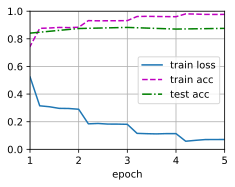

In [28]:
import torch 
lr, num_epochs = 0.001, 5 
trainer = torch.optim.Adam(net.parameters(), lr=lr) 
loss = nn.CrossEntropyLoss(reduction="none") 
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [29]:
d2l.predict_sentiment(net, vocab, 'this movie is so great')

'positive'

In [30]:
d2l.predict_sentiment(net, vocab, 'this movie is so bad')

'negative'

In [31]:
import os 
import re 
import torch 
from torch import nn 
from d2l import torch as d2l

#@save
d2l.DATA_HUB['SNLI'] = ('https://nlp.stanford.edu/projects/snli/snli_1.0.zip',
                        '9fcde07509c7e87ec61c640c1b2753d9041758e4')
data_dir = d2l.download_extract('SNLI')

In [33]:
#@save 
def read_snli(data_dir, is_train):
    def extract_text(s):
        s = re.sub('\\(', '', s)
        s = re.sub('\\)', '', s)
        s = re.sub('\\s{2,}', ' ', s)
        return s.strip()
    label_set = {'entailment': 0, 'contradiction': 1, 'neutral': 2}
    file_name = os.path.join(data_dir, 'snli_1.0_train.txt' if is_train else 'snli_1.0_test.txt')
    with open(file_name, 'r') as f:
        rows = [row.split('\t') for row in f.readlines()[1:]]
    premises = [extract_text(row[1]) for row in rows if row[0] in label_set] 
    hypotheses = [extract_text(row[2]) for row in rows if row[0] in label_set] 
    labels = [label_set[row[0]] for row in rows if row[0] in label_set] 
    return premises, hypotheses, labels

In [34]:
train_data = read_snli(data_dir, is_train=True)
for x0, x1, y in zip(train_data[0][:3], train_data[1][:3], train_data[2][:3]):
    print('premise:', x0) 
    print('hypothesis:', x1) 
    print('label:', y)

premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is training his horse for a competition .
label: 2
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is at a diner , ordering an omelette .
label: 1
premise: A person on a horse jumps over a broken down airplane .
hypothesis: A person is outdoors , on a horse .
label: 0


In [37]:
class SNLIDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, num_steps, vocab=None):
        self.num_steps = num_steps
        all_premise_tokens = d2l.tokenize(dataset[0])
        all_hypothesis_tokens = d2l.tokenize(dataset[1])
        if vocab is None:
            self.vocab = d2l.Vocab(all_premise_tokens + all_hypothesis_tokens,min_freq=5, reserved_tokens=['<pad>'])
        else:
            self.vocab = vocab 
        self.premises = self._pad(all_premise_tokens) 
        self.hypotheses = self._pad(all_hypothesis_tokens)
        self.labels = torch.tensor(dataset[2])          
        print('read ' + str(len(self.premises)) + ' examples')
    
    def _pad(self, lines):
        return torch.tensor([d2l.truncate_pad( self.vocab[line], self.num_steps, self.vocab['<pad>']) for line in lines])
    def __getitem__(self, idx):
        return (self.premises[idx], self.hypotheses[idx]), self.labels[idx]
    def __len__(self):
        return len(self.premises)

In [38]:
def load_data_snli(batch_size, num_steps = 50):
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('SNLI')
    train_data = read_snli(data_dir, True)
    test_data = read_snli(data_dir, False)
    train_set = SNLIDataset(train_data, num_steps)
    test_set = SNLIDataset(test_data, num_steps, train_set.vocab)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(test_set, batch_size, shuffle=False, num_workers=num_workers)
    return train_iter, test_iter, train_set.vocab

train_iter, test_iter, vocab = load_data_snli(128, 50) 
len(vocab)

read 549367 examples
read 9824 examples


18678

In [39]:
for X, Y in train_iter:
    print(X[0].shape) 
    print(X[1].shape) 
    print(Y.shape) 
    break

torch.Size([128, 50])
torch.Size([128, 50])
torch.Size([128])


In [40]:
import torch 
from torch import nn
from torch.nn import functional as F 
from d2l import torch as d2l

In [41]:
def mlp(num_inputs, num_hiddens, flatten):
    net = []
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_inputs, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    net.append(nn.Dropout(0.2))
    net.append(nn.Linear(num_hiddens, num_hiddens))
    net.append(nn.ReLU())
    if flatten:
        net.append(nn.Flatten(start_dim=1))
    return nn.Sequential(*net)

In [42]:
class Attend(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Attend, self).__init__(**kwargs)
        self.f = mlp(num_inputs, num_hiddens, flatten=False)
    
    def forward(self, A, B):
        f_A = self.f(A)
        f_B = self.f(B)
        e = torch.bmm(f_A, f_B.permute(0,2,1))
        beta = torch.bmm(F.softmax(e, dim=-1), B)
        alpha = torch.bmm(F.softmax(e.permute(0,2,1), dim=-1), A)
        return beta, alpha

In [44]:
class Compare(nn.Module):
    def __init__(self, num_inputs, num_hiddens, **kwargs):
        super(Compare, self).__init__(**kwargs)
        self.g = mlp(num_inputs, num_hiddens, flatten=False)
    
    def forward(self, A, B, beta, alpha):
        V_A = self.g(torch.cat([A, beta], dim=2))
        V_B = self.g(torch.cat([B, alpha], dim=2))
        return V_A, V_B

In [45]:
class Aggregate(nn.Module):
    def __init__(self, num_inputs, num_hiddens, num_outputs, **kwargs):
        super(Aggregate, self).__init__(**kwargs)
        self.h = mlp(num_inputs, num_hiddens, flatten=True)
        self.linear = nn.Linear(num_hiddens, num_outputs)
    def forward(self, V_A, V_B):
        V_A = V_A.sum(dim=1)
        V_B = V_B.sum(dim=1)
        Y_hat = self.linear(self.h(torch.cat([V_A, V_B], dim=1)))
        return Y_hat

In [46]:
class DecomposableAttention(nn.Module):
    def __init__(self, vocab, embed_size, num_hiddens, num_inputs_attend=100, 
                 num_inputs_compare=200, num_inputs_agg=400, **kwargs):
        super(DecomposableAttention, self).__init__(**kwargs)
        self.embedding = nn.Embedding(len(vocab), embed_size) 
        self.attend = Attend(num_inputs_attend, num_hiddens)
        self.compare = Compare(num_inputs_compare, num_hiddens)
        self.aggregate = Aggregate(num_inputs_agg, num_hiddens, num_outputs = 3)
    
    def forward(self, X):
        premises, hypotheses = X
        A = self.embedding(premises)
        B = self.embedding(hypotheses)
        beta, alpha = self.attend(A, B)
        V_A, V_B = self.compare(A, B, beta, alpha)
        Y_hat = self.aggregate(V_A,V_B)
        return Y_hat        

In [47]:
batch_size, num_steps = 256, 50 
train_iter, test_iter, vocab = d2l.load_data_snli(batch_size, num_steps)

read 549367 examples
read 9824 examples


In [48]:
embed_size, num_hiddens, devices = 100, 200, d2l.try_all_gpus() 
net = DecomposableAttention(vocab, embed_size, num_hiddens)
glove_embedding = d2l.TokenEmbedding('glove.6b.100d')
embeds = glove_embedding[vocab.idx_to_token]
net.embedding.weight.data.copy_(embeds);

loss 0.496, train acc 0.805, test acc 0.824
6544.3 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3), device(type='cuda', index=4), device(type='cuda', index=5), device(type='cuda', index=6), device(type='cuda', index=7)]


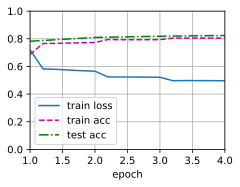

In [49]:
lr, num_epochs = 0.001, 4 
trainer = torch.optim.Adam(net.parameters(), lr=lr) 
loss = nn.CrossEntropyLoss(reduction="none") 
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)

In [50]:
def predict_snli(net, vocab, premise, hypothesis):
    net.eval()
    premise = torch.tensor(vocab[premise], device=d2l.try_gpu())
    hypothesis = torch.tensor(vocab[hypothesis], device=d2l.try_gpu())
    label = torch.argmax(net([premise.reshape((1, -1)), hypothesis.reshape((1, -1))]), dim=1) 
    return 'entailment' if label == 0 else 'contradiction' if label == 1 else 'neutral'

In [51]:
predict_snli(net, vocab, ['he', 'is', 'good', '.'], ['he', 'is', 'bad', '.'])

'contradiction'

In [52]:
import json 
import multiprocessing 
import os 
import torch 
from torch import nn 
from d2l import torch as d2l

In [53]:
d2l.DATA_HUB['bert.base'] = (d2l.DATA_URL + 'bert.base.torch.zip','225d66f04cae318b841a13d32af3acc165f253ac')
d2l.DATA_HUB['bert.small'] = (d2l.DATA_URL + 'bert.small.torch.zip','c72329e68a732bef0452e4b96a1c341c8910f81f')

In [55]:
def load_pretrained_model(pretrained_model, num_hiddens, ffn_num_hiddens, num_heads, 
                          num_blks, dropout, max_len, devices):
    data_dir = d2l.download_extract(pretrained_model)
    vocab = d2l.Vocab()
    vocab.idx_to_token = json.load(open(os.path.join(data_dir, 'vocab.json')))
    vocab.token_to_idx = {token: idx for idx, token in enumerate(vocab.idx_to_token)}
    bert = d2l.BERTModel(len(vocab), num_hiddens, ffn_num_hiddens=ffn_num_hiddens, 
                         num_heads=4,num_blks=2, dropout=0.2, max_len=max_len)
    bert.load_state_dict(torch.load(os.path.join(data_dir, 'pretrained.params')))
    return bert, vocab

In [56]:
devices = d2l.try_all_gpus() 
bert, vocab = load_pretrained_model('bert.small', num_hiddens=256, ffn_num_hiddens=512, num_heads=4,
num_blks=2, dropout=0.1, max_len=512, devices=devices)

/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [57]:
class SNLIBERTDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, max_len, vocab=None):
        all_premise_hypothesis_tokens = [[ p_tokens, h_tokens] for p_tokens, h_tokens 
                                         in zip( *[d2l.tokenize([s.lower() for s in sentences]) 
                                                   for sentences in dataset[:2]])]
        self.labels = torch.tensor(dataset[2])
        self.vocab = vocab 
        self.max_len = max_len
        (self.all_token_ids, self.all_segments, self.valid_lens) = self._preprocess(all_premise_hypothesis_tokens) 
        print('read ' + str(len(self.all_token_ids)) + ' examples')
        
    def _preprocess(self, all_premise_hypothesis_tokens):
        pool = multiprocessing.Pool(4) 
        # Use 4 worker processes o
        out = pool.map(self._mp_worker, all_premise_hypothesis_tokens) 
        all_token_ids = [token_ids for token_ids, segments, valid_len in out] 
        all_segments = [segments for token_ids, segments, valid_len in out] 
        valid_lens = [valid_len for token_ids, segments, valid_len in out] 
        return (torch.tensor(all_token_ids, dtype=torch.long), 
                torch.tensor(all_segments, dtype=torch.long),
                torch.tensor(valid_lens))
    
    def _mp_worker(self, premise_hypothesis_tokens):
        p_tokens, h_tokens = premise_hypothesis_tokens 
        self._truncate_pair_of_tokens(p_tokens, h_tokens)
        tokens, segments = d2l.get_tokens_and_segments(p_tokens, h_tokens)
        token_ids = self.vocab[tokens]+[self.vocab['<pad>']] * (self.max_len - len(tokens))
        segments = segments + [0]*(self.max_len - len(tokens))
        valid_len = len(tokens)
        return token_ids, segments, valid_len
    
    def _truncate_pair_of_tokens(self, p_tokens, h_tokens):
        while len(p_tokens) + len(h_tokens) > self.max_len -3: #cls, sep, sep tokens for BERT input
            if len(p_tokens) > len(h_tokens):
                p_tokens.pop()
            else:
                h_tokens.pop()
    
    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx], self.valid_lens[idx]), self.labels[idx]
    
    def __len__(self):
        return len(self.all_token_ids)

In [58]:
batch_size, max_len, num_workers = 512, 127, d2l.get_dataloader_workers()
data_dir = d2l.download_extract('SNLI')
train_set = SNLIBERTDataset(d2l.read_snli(data_dir, True), max_len, vocab)
test_set = SNLIBERTDataset(d2l.read_snli(data_dir, False), max_len, vocab)
test_iter = torch.utils.data.DataLoader(train_set, batch_size, shuffle=True, num_workers=num_workers)
train_iter = torch.utils.data.DataLoader(test_set, batch_size, num_workers=num_workers)

read 549367 examples
read 9824 examples


In [59]:
class BERTClassifier(nn.Module):
    def __init__(self, bert):
        super(BERTClassifier, self).__init__()
        self.encoder = bert.encoder
        self.hidden = bert.hidden
        self.output = nn.LazyLinear(3)
        
    def forward(self, inputs):
        tokens_X, segments_X, valid_lens_x = inputs
        encoded_X = self.encoder(tokens_X, segments_X, valid_lens_x)
        return self.output(self.hidden(encoded_X[:, 0, :]))


In [60]:
net = BERTClassifier(bert)

/home/shkim/anaconda3/envs/d2l/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


loss 0.812, train acc 0.642, test acc 0.573
5482.9 examples/sec on [device(type='cuda', index=0), device(type='cuda', index=1), device(type='cuda', index=2), device(type='cuda', index=3), device(type='cuda', index=4), device(type='cuda', index=5), device(type='cuda', index=6), device(type='cuda', index=7)]


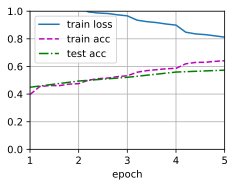

In [61]:
lr, num_epochs = 1e-4, 5
trainer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.CrossEntropyLoss(reduction='none')
net(next(iter(train_iter))[0])
d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs, devices)